In [1]:
# %%
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.optimize import minimize
from collections import deque
# Import the custom Model class
from Model import Model
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s:%(message)s')

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)
tf.random.set_seed(123)

plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['AGG','DBC','VTI','^VIX']

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252
VOLATILITY_SCALING = False
# Define transaction cost rate
C = 0.0001  # 0.01%

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")

Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_11812\1470264350.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# %%
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, '2006-01-01', '2020-04-30')
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")

[*********************100%%**********************]  4 of 4 completed

Data fetched successfully. Sample data:
Ticker            AGG        DBC        VTI   ^VIX
Date                                              
2006-02-06  56.124329  20.889496  44.654274  13.04
2006-02-07  56.085152  20.285255  44.219482  13.59
2006-02-08  56.057117  20.198933  44.537624  12.83
2006-02-09  56.090794  20.388838  44.452789  13.12
2006-02-10  55.973164  20.017662  44.544685  12.87
Data covers 3582 trading days with 4 assets.


In [3]:
# %%
def preprocess_data(data, rolling_window=50):
    """
    Prepares data by calculating 50-day rolling averages and returns.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets
    - rolling_window: Window size for the rolling average

    Returns:
    - normalized_data: Smoothed prices, normalized to start at 1 for each asset
    - returns: Smoothed returns using a rolling mean of percentage changes
    """
    # Calculate rolling mean for prices and returns to smooth the data
    smoothed_prices = (data.rolling(window=rolling_window).mean()).dropna()
    smoothed_returns = (data.pct_change().rolling(window=rolling_window).mean()).dropna()
    # Normalize prices to start each asset's time series at 1
    normalized_data = smoothed_prices / smoothed_prices.iloc[0]
    
    return normalized_data, smoothed_returns


# Run preprocessing and display sample data
normalized_data, smoothed_returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(smoothed_returns.head())


Data preprocessing complete. Sample normalized data:
Ticker           AGG       DBC       VTI      ^VIX
Date                                              
2006-04-18  1.000000  1.000000  1.000000  1.000000
2006-04-19  0.999786  1.001443  1.000798  0.997130
2006-04-20  0.999555  1.003226  1.001815  0.993875
2006-04-21  0.999332  1.005552  1.002683  0.991806
2006-04-24  0.999172  1.007249  1.003528  0.989520

Sample daily returns:
Ticker           AGG       DBC       VTI      ^VIX
Date                                              
2006-04-19 -0.000212  0.001441  0.000813 -0.001952
2006-04-20 -0.000229  0.001788  0.001035 -0.002230
2006-04-21 -0.000221  0.002295  0.000882 -0.001198
2006-04-24 -0.000157  0.001709  0.000862 -0.001374
2006-04-25 -0.000182  0.002136  0.000757 -0.000993


In [4]:
class Portfolio:
    def __init__(self, initial_cash: float, asset_names: List[str], transaction_cost: float = 0.0001):
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.transaction_cost_rate = transaction_cost
        self.asset_names = asset_names
        self.current_weights = np.zeros(len(asset_names))
        self.portfolio_values = []
        self.weights_history = []
        self.dates = []
        self.transaction_cost = 0.0  # Initialize transaction cost

    def rebalance(self, new_weights: np.array):
        # Compute transaction costs
        if len(self.weights_history) == 0:
            transaction_cost = self.transaction_cost_rate * np.sum(np.abs(new_weights))
        else:
            transaction_cost = self.transaction_cost_rate * np.sum(np.abs(new_weights - self.current_weights))
        self.transaction_cost = transaction_cost * self.current_value
        self.current_weights = new_weights.copy()
        self.weights_history.append(self.current_weights.copy())

    def update_portfolio_value(self, asset_returns: np.array, current_date: pd.Timestamp):
        # Compute portfolio return
        portfolio_return = np.dot(self.current_weights, asset_returns)
        self.current_value = self.current_value * (1 + portfolio_return) - self.transaction_cost
        self.transaction_cost = 0.0
        self.portfolio_values.append(self.current_value)
        self.dates.append(current_date)
    
    def get_portfolio_values(self):
        return self.portfolio_values


In [5]:
# %%
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing various performance metrics.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Number of days
    N = len(portfolio_returns)

    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns) if len(downside_returns) > 0 else 0
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR) if downside_std_dev != 0 else np.nan
    
    # Calculate Maximum Drawdown
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (cumulative_max - portfolio_values) / cumulative_max
    max_drawdown = np.max(drawdowns)
    
    # Expected return (annualized)
    cumulative_return = (portfolio_values[-1] / portfolio_values[0]) - 1
    annualized_return = (1 + cumulative_return) ** (TRADING_DAYS_PER_YEAR / N) - 1

    # Standard deviation of returns (annualized)
    annualized_std = std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)

    # Percentage of positive returns
    positive_returns = portfolio_returns[portfolio_returns > 0]
    percentage_positive = len(positive_returns) / len(portfolio_returns) * 100

    # Average profit / average loss (profit/loss ratio)
    average_profit = np.mean(portfolio_returns[portfolio_returns > 0]) if len(positive_returns) > 0 else 0
    average_loss = np.mean(portfolio_returns[portfolio_returns < 0]) if len(portfolio_returns[portfolio_returns < 0]) > 0 else 0
    profit_loss_ratio = (average_profit / -average_loss) if average_loss != 0 else np.nan

    metrics = {
        "Annualized Return": annualized_return,
        "Annualized Std Dev": annualized_std,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "% Positive Returns": percentage_positive,
        "Profit/Loss Ratio": profit_loss_ratio
    }
    
    return metrics


In [6]:
def volatility_scaling(weights, returns_past, target_vol=0.1):
    """
    Scales the portfolio weights based on the target volatility and ex-ante volatility estimates.

    Parameters:
    - weights: Numpy array of current portfolio weights
    - returns_past: Pandas DataFrame of past returns (50 days)
    - target_vol: Target portfolio volatility (default 10%)

    Returns:
    - scaled_weights: Numpy array of scaled portfolio weights
    """
    # Calculate exponentially weighted moving standard deviation (50-day window)
    vol_estimates = returns_past.ewm(span=50).std().iloc[-1].values  # Shape: (num_assets,)

    # Avoid division by zero
    vol_estimates = np.where(vol_estimates == 0, 1e-6, vol_estimates)

    # Calculate scaling factors: target_vol / vol_estimates
    scaling_factors = target_vol / vol_estimates

    # Apply scaling to weights
    scaled_weights = weights * scaling_factors

    # Normalize weights to sum to 1
    scaled_weights /= np.sum(scaled_weights)

    return scaled_weights


In [7]:
# %%
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

# Define function to get MV weights
def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

# Define function to get MD weights
def maximum_diversification(returns):
    """
    Perform maximum diversification optimization based on the given returns.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimal_weights: Array of portfolio weights that maximize diversification.
    """
    # Calculate asset volatilities (standard deviation of each asset’s returns)
    asset_volatilities = returns.std()

    # Calculate the covariance matrix of returns
    cov_matrix = returns.cov()

    # Define the diversification ratio to be maximized
    def neg_diversification_ratio(weights):
        # Calculate the weighted average asset volatility
        weighted_volatility = np.dot(weights, asset_volatilities)
        
        # Calculate the portfolio volatility as the weighted covariance matrix
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Diversification ratio (we negate this because we want to maximize it)
        diversification_ratio = weighted_volatility / portfolio_volatility
        return -diversification_ratio  # Negate to turn this into a minimization problem

    # Constraints: weights sum to 1, and each weight between 0 and 1 (long-only portfolio)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(asset_volatilities)))

    # Initial guess (equal allocation)
    init_guess = np.ones(len(asset_volatilities)) / len(asset_volatilities)

    # Optimize to find weights that maximize diversification ratio
    result = minimize(neg_diversification_ratio, init_guess, bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    
    return optimal_weights


In [8]:
def average_metrics(metrics_list):
    """
    Calculates the average of each metric in the list of metrics.
    """
    avg_metrics = {}
    keys = metrics_list[0].keys()
    for key in keys:
        avg_metrics[key] = np.mean([m[key] for m in metrics_list])
    return avg_metrics


In [ ]:
def plot_performance_comparison(portfolio_histories, periods, strategies):
    """
    Plots the actual portfolio values for each strategy across all testing periods in a grid format,
    swapping rows and columns such that rows represent strategies and columns represent periods.
    
    Parameters:
    - portfolio_histories: Dictionary containing portfolio value histories for each strategy.
    - periods: List of tuples containing (training_end, testing_start, testing_end) for each period.
    - strategies: List of strategy names to plot.
    """
    num_periods = len(periods)
    num_strategies = len(strategies)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_strategies, num_periods, figsize=(5*num_periods, 3*num_strategies), sharex=False, sharey=False)
    fig.suptitle('Portfolio Performance Comparison (Raw Values)', fontsize=16, y=0.92)
    
    for strat_idx, strategy in enumerate(strategies):
        for period_idx, period in enumerate(periods):
            training_end, testing_start, testing_end = period
            
            # Handle axes indexing for single row or column
            if num_periods == 1 and num_strategies == 1:
                ax = axes
            elif num_periods == 1:
                ax = axes[strat_idx]
            elif num_strategies == 1:
                ax = axes[period_idx]
            else:
                ax = axes[strat_idx, period_idx]
            
            # Get the corresponding portfolio history
            history = portfolio_histories[strategy][period_idx]
            dates = history['dates']
            values = history['values']
            # Plot raw portfolio values
            ax.plot(dates, values, label=f"{strategy}")
            ax.set_title(f"{strategy} | {testing_start} to {testing_end}")
            ax.set_xlabel('Date')
            ax.set_ylabel('Portfolio Value ($)')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [10]:
# %%
# Define testing periods
training_end_dates = ['2010-12-31', '2012-12-31', '2014-12-31', '2016-12-31', '2018-12-31']
testing_start_dates = ['2011-01-01', '2013-01-01', '2015-01-01', '2017-01-01', '2019-01-01']
testing_end_dates = ['2012-12-31', '2014-12-31', '2016-12-31', '2018-12-31', '2020-12-31']

periods = list(zip(training_end_dates, testing_start_dates, testing_end_dates))

# Initialize lists to store performance metrics for each model
lstm_metrics = []
mvo_metrics = []
md_metrics = []
ew_metrics = []
# Initialize a dictionary to store portfolio histories for each strategy
portfolio_histories = {
    'LSTM': [],
    'MVO': [],
    'MD': [],
    'EW': []
}

initial_cash = 100000

In [11]:
for period in periods:
    training_end, testing_start, testing_end = period
    print(f"\nProcessing period: Training up to {training_end}, Testing from {testing_start} to {testing_end}")

    # Get training data
    training_data = data.loc[:training_end].copy()
    # Get testing data
    testing_data = data.loc[testing_start:testing_end].copy()
    testing_returns = testing_data.pct_change().fillna(0)
    # Ensure we have enough data
    if len(testing_data) < 50:
        print("Not enough data for testing period")
        continue

    # LSTM Model
    lstm_model = Model()
    # Train the model on the training data
    lstm_model.train(training_data)

    # Initialize portfolio
    portfolio_lstm = Portfolio(initial_cash, asset_names=testing_data.columns.tolist(), transaction_cost=C)

    # Loop through each day in the testing period for LSTM
    for i in range(50, len(testing_data)):
        # Get past 50 days of data for input
        input_sequence = testing_data.iloc[i - 50:i]
        # Prepare the input (same preprocessing as during training)
        returns_sequence = input_sequence.pct_change().fillna(0)
        combined_sequence = pd.concat([input_sequence, returns_sequence], axis=1).values

        # Predict allocation for the day
        allocation = lstm_model.predict_allocation(combined_sequence)
        print("LSTM Allocation:", allocation)
        # Apply volatility scaling if needed
        if VOLATILITY_SCALING:
            # Get past returns for volatility estimation
            returns_past = testing_returns.iloc[i - 50:i]
            allocation = volatility_scaling(allocation, returns_past, target_vol=TARGET_VOL)

        # Rebalance the portfolio
        portfolio_lstm.rebalance(allocation)

        # Get today's returns from precomputed returns
        today_return = testing_returns.iloc[i].values
        current_date = testing_data.index[i]

        # Update portfolio value
        portfolio_lstm.update_portfolio_value(today_return, current_date)

    # Get portfolio values and store in histories
    portfolio_values_lstm = portfolio_lstm.get_portfolio_values()
    portfolio_dates_lstm = portfolio_lstm.dates
    portfolio_histories['LSTM'].append({'dates': portfolio_dates_lstm, 'values': portfolio_values_lstm})
    # Calculate and store performance metrics for LSTM
    metrics_lstm = calculate_metrics(portfolio_values_lstm)
    lstm_metrics.append(metrics_lstm)

    # Mean-Variance Optimization (MVO) Model
    returns_full_testing = data.loc[:testing_end].pct_change().dropna()
    returns_testing = data.loc[testing_start:testing_end].pct_change().dropna()

    # Get indices of testing dates in returns
    testing_indices = returns_full_testing.index.get_indexer_for(returns_testing.index)

    # Initialize portfolio
    portfolio_mv = Portfolio(initial_cash, asset_names=testing_data.columns.tolist(), transaction_cost=C)

    for i in range(50, len(testing_indices)):
        # Get the past 50 days of rolling means
        input_data = returns_full_testing.iloc[i - 50:i]
        weights_mv = mean_variance_optimized_strategy(input_data)

        # Apply volatility scaling if required
        if VOLATILITY_SCALING:
            weights_mv = volatility_scaling(weights_mv, returns_full_testing.iloc[i - 50:i], target_vol=TARGET_VOL)

        print("MVO Allocation:", weights_mv)

        # Rebalance the portfolio
        portfolio_mv.rebalance(weights_mv)

        # Today's returns
        today_return = returns_testing.iloc[i].values
        current_date = returns_testing.index[i]

        # Update portfolio value
        portfolio_mv.update_portfolio_value(today_return, current_date)

    # Get portfolio values and store in histories
    portfolio_values_mv = portfolio_mv.get_portfolio_values()
    portfolio_dates_mv = portfolio_mv.dates
    portfolio_histories['MVO'].append({'dates': portfolio_dates_mv, 'values': portfolio_values_mv})
    # Calculate and store performance metrics for MVO
    metrics_mv = calculate_metrics(portfolio_values_mv)
    mvo_metrics.append(metrics_mv)

    # Maximum Diversification (MD) Model
    portfolio_md = Portfolio(initial_cash, asset_names=testing_data.columns.tolist(), transaction_cost=C)

    for i in range(50, len(testing_indices)):
        input_data = returns_full_testing.iloc[i - 50:i]
        weights_md = maximum_diversification(input_data)
        # Apply volatility scaling if required
        if VOLATILITY_SCALING:
            weights_md = volatility_scaling(weights_md, returns_full_testing.iloc[i - 50:i], target_vol=TARGET_VOL)

        print("MD Allocation:", weights_md)

        # Rebalance the portfolio
        portfolio_md.rebalance(weights_md)

        # Today's returns
        today_return = returns_testing.iloc[i].values
        current_date = returns_testing.index[i]

        # Update portfolio value
        portfolio_md.update_portfolio_value(today_return, current_date)

    # Get portfolio values and store in histories
    portfolio_values_md = portfolio_md.get_portfolio_values()
    portfolio_dates_md = portfolio_md.dates
    portfolio_histories['MD'].append({'dates': portfolio_dates_md, 'values': portfolio_values_md})
    # Calculate and store performance metrics for MD
    metrics_md = calculate_metrics(portfolio_values_md)
    md_metrics.append(metrics_md)

    # Equal Weighted Strategy with minimal rebalancing
    portfolio_ew = Portfolio(initial_cash, asset_names=testing_data.columns.tolist(), transaction_cost=C)
    weights_ew = equal_weighted_strategy(returns_full_testing)
    for i in range(0, len(testing_indices)):
        today_return = returns_testing.iloc[i].values
        current_date = returns_testing.index[i]
        if i % 252 == 0:
            # Rebalance every year
            portfolio_ew.rebalance(weights_ew)

        portfolio_ew.update_portfolio_value(today_return, current_date)
    # Get portfolio values and store in histories
    portfolio_values_ew = portfolio_ew.get_portfolio_values()
    portfolio_dates_ew = portfolio_ew.dates
    portfolio_histories['EW'].append({'dates': portfolio_dates_ew, 'values': portfolio_values_ew})
    # Calculate and store performance metrics for EW
    metrics_ew = calculate_metrics(portfolio_values_ew)
    ew_metrics.append(metrics_ew)



Processing period: Training up to 2010-12-31, Testing from 2011-01-01 to 2012-12-31
Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 9.0343e-04
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0367
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0571
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0730
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.0795
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0898
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1028
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1089
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -0.1199
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1166
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1173
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1220
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1283
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1295
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: -0.0135
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: -0.0388
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: -0.0462
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0520
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.0758
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -0.1002
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1160
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1333
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1454
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -0.1509
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -0.1577
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -0.1579
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: -0.1624
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -0.1631
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: -0.0964
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1410
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1629
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1790
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1821
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1878
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1902
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1951
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1959
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1997
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1987
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.2030
Epoch 13/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.2071
Epoch 14/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.2055
Epoch 15/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: -0.0607
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1042
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1169
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1252
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1401
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1550
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1683
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1756
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1784
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1830
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: -0.1868
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1891
Epoch 13/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1900
Epoch 14/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1915
Epoch 15/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: -0.0082
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0421
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0913
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1104
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1182
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1277
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1304
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -0.1354
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1385
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -0.1415
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1435
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1488
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1501
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1494
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - 

In [12]:
# Calculate average metrics for each model
lstm_avg_metrics = average_metrics(lstm_metrics)
mvo_avg_metrics = average_metrics(mvo_metrics)
md_avg_metrics = average_metrics(md_metrics)
ew_avg_metrics = average_metrics(ew_metrics)

In [13]:
# Print the average metrics
print("\nAverage Metrics for LSTM Model:")
for key, value in lstm_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MVO Strategy:")
for key, value in mvo_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MD Strategy:")
for key, value in md_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for Equal Weighted Strategy:")
for key, value in average_metrics(ew_metrics).items():
    print(f"{key}: {value:.4f}")


Average Metrics for LSTM Model:
Annualized Return: 0.3641
Annualized Std Dev: 0.1321
Sharpe Ratio: 2.4247
Sortino Ratio: 4.4055
Max Drawdown: 0.0697
% Positive Returns: 54.9696
Profit/Loss Ratio: 1.3485

Average Metrics for MVO Strategy:
Annualized Return: 0.1329
Annualized Std Dev: 0.1534
Sharpe Ratio: 1.0510
Sortino Ratio: 1.7619
Max Drawdown: 0.0984
% Positive Returns: 56.3339
Profit/Loss Ratio: 1.0720

Average Metrics for MD Strategy:
Annualized Return: 0.1236
Annualized Std Dev: 0.0904
Sharpe Ratio: 1.7648
Sortino Ratio: 2.8769
Max Drawdown: 0.0765
% Positive Returns: 54.5391
Profit/Loss Ratio: 1.1711

Average Metrics for Equal Weighted Strategy:
Annualized Return: 0.2391
Annualized Std Dev: 0.2957
Sharpe Ratio: 0.8566
Sortino Ratio: 1.8396
Max Drawdown: 0.1626
% Positive Returns: 47.6825
Profit/Loss Ratio: 1.2908


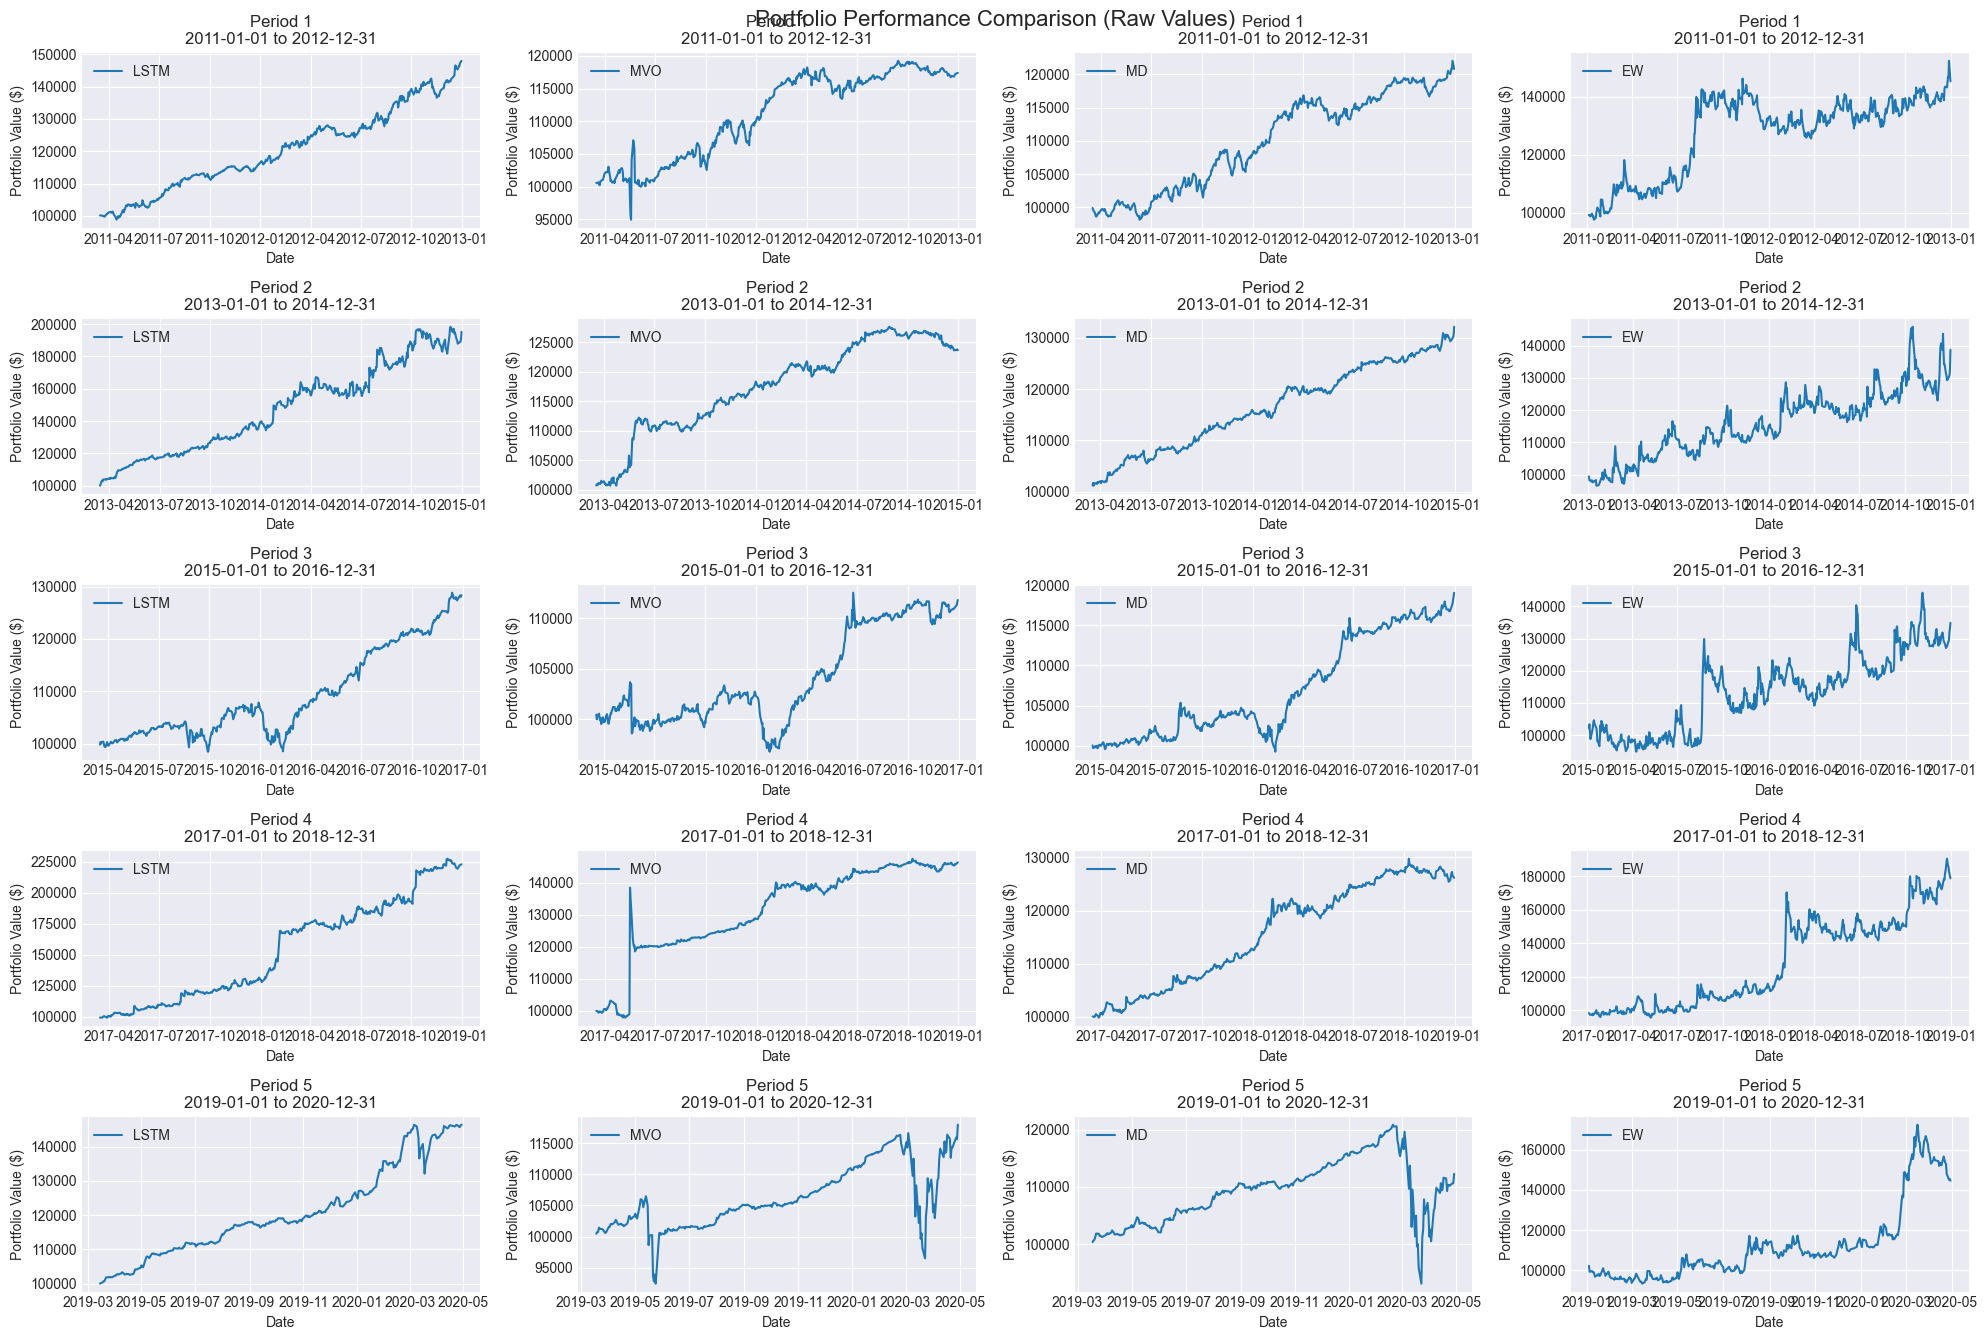

In [17]:
strategies = ['LSTM', 'MVO', 'MD', 'EW']
plot_performance_comparison(portfolio_histories, periods, strategies)